# Gauss-Newton for XRD

In [1]:
from XRDXRFutils import GaussNewton, DataXRD, SpectraXRD, DatabaseXRD, PhaseList, PhaseMap
from matplotlib.pyplot import xlim,ylim,xlabel,ylabel,legend,plot,fill_between,imshow,subplots,sca,savefig,figure,colorbar
from numpy import prod,array,minimum,maximum,log,zeros,trapz,where,amax,max,sqrt,sign,fabs,exp,linspace
from numpy.linalg import eig,det
from multiprocessing import Pool

### loading data

In [2]:
#path_xrd = '../../dati/Oslo/Profilo/XRD/'
path_xrd = '/home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/'

#path_database = '../../dati/Database/'
path_database = '/home/zdenek/Projects/XRDXRFutils/Database'

#data = DataXRD().read_params(path_xrd + 'Scanning_Parameters.txt').read(path_xrd).calibrate_from_file(path_xrd + 'calibration.ini').save_h5(path_xrd + 'xrd.h5')
data = DataXRD().load_h5(path_xrd + 'xrd.h5')
data.calibrate_from_parameters([-1186.6, 1960.3, 51])

database = DatabaseXRD().read_cifs(path_database)

lazurite = database['Lazurite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][1]
barite = database['Barite'][0]
spinel = database['Spinel'][0]
calcite = database['Calcite'][0]
hematite = database['Hematite'][4]

phases = PhaseList([hydrocerussite,lazurite,cinnabar])
#phases = PhaseList([hydrocerussite,lazurite,cinnabar,
                    #PhaseList([hydrocerussite,cinnabar]),
                    #PhaseList([hydrocerussite,lazurite]),
                    #PhaseList([cinnabar,lazurite])])

min_theta = 0
max_theta = 53
min_intensity = 0.05
first_n_peaks = None

Loading: /home/zdenek/Projects/pyMaXRDXRF/M491/ProfiloXRD/xrd.h5


In [5]:
%%time
pm = PhaseMap(data, phases, min_theta = min_theta, max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks)

CPU times: user 13.7 s, sys: 2.35 s, total: 16 s
Wall time: 22.4 s


In [7]:
%%time
pm.search()

CPU times: user 1min 55s, sys: 22.2 s, total: 2min 17s
Wall time: 2min 11s


[-1177.67898367  1945.15347404    51.        ]


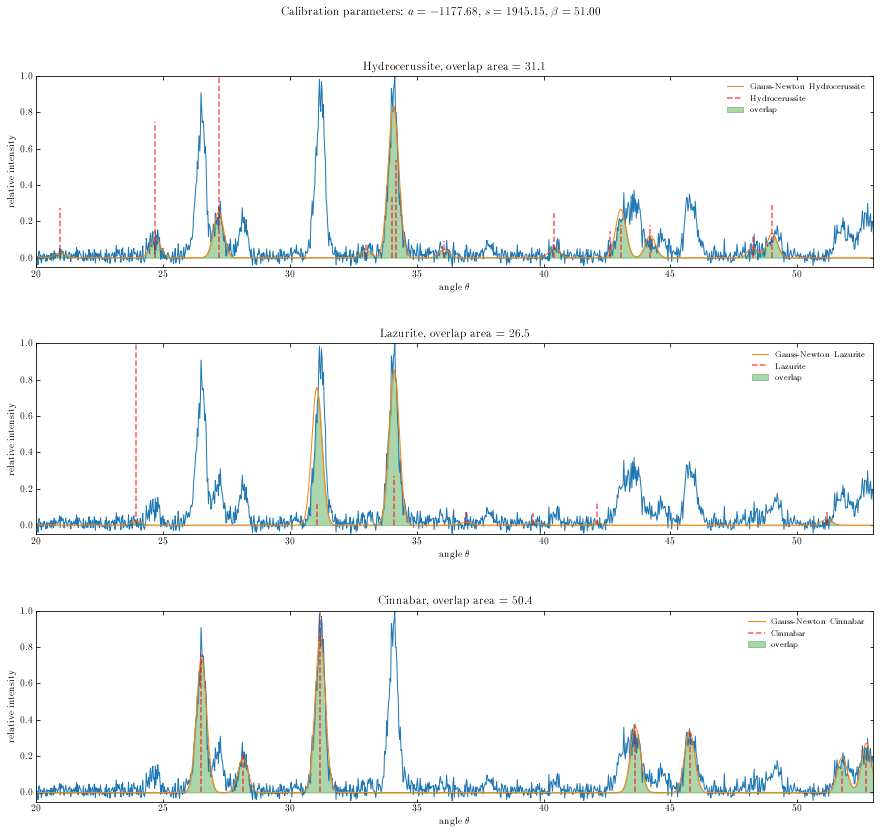

In [8]:
%matplotlib inline

r = pm.list_phase_search[1600]

fig, axes = subplots(len(r), 1, figsize = (15, 4 * len(r)))
fig.subplots_adjust(hspace = 0.4, bottom = 0.06, top = 0.9)
print(r.opt)

fig.suptitle(r'Calibration parameters: $a = %.2f$, $s=%.2f$, $\beta=%.2f$'%(r.opt[0], r.opt[1], r.opt[2]))

for i in range(len(r)):
    ax = axes[i]
    g = r[i]
    sca(ax)

    ax.set_title(f'{g.label}, overlap area = {g.overlap_area():.1f}')
    g.plot_spectra(lw = 1)
    g.plot('-', label='Gauss-Newton %s'%g.label, lw=1)
    g.phase.plot('r', alpha=0.66)

    fill_between(g.theta.squeeze(), g.overlap(), color = 'g', alpha = 0.33, label='overlap')

    legend(frameon = False)
    ax.set_ylim(-0.05, 1)
    ax.set_xlim(20, 53)
    ax.set_xlabel(r'angle $\theta$')
    ax.set_ylabel(r'relative intensity')

savefig('doc/fits.png', dpi = 900)

## Calibration

per pixel calibration dependence

a,b: [-3.48336148e-01 -5.02830711e+02] [ -0.80627099 394.28244971]
-1185.7964056272133 1960.651223717015


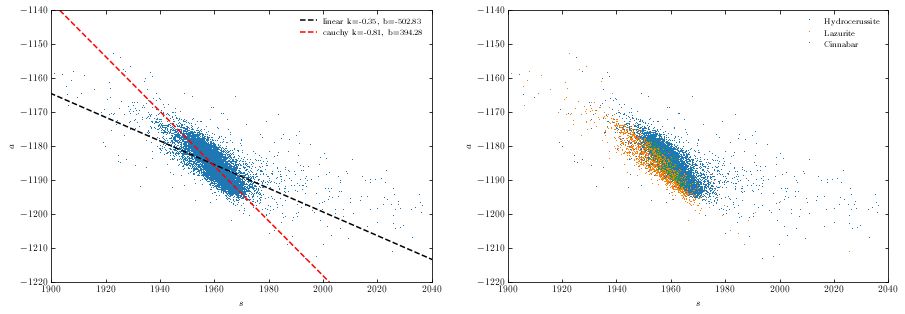

In [9]:
%matplotlib inline
from numpy import linspace
from scipy.optimize import curve_fit, least_squares

def f(x,a,b):
    return a*x + b
def loss(x,t,y):
    return (x[0]*t + x[1]) - y

a = array([r.selected.opt[0] for r in pm.list_phase_search])
s = array([r.selected.opt[1] for r in pm.list_phase_search])
idx = array([r.idx for r in pm.list_phase_search])
x = linspace(s.min(), s.max())

opt,var = curve_fit(f,s,a)

res = least_squares(loss,x0=opt,args=(s,a),loss='cauchy')
print('a,b:',opt,res['x'])

linear_y = f(x,*opt)
cauchy_y = f(x,*res['x'])

fig,ax = subplots(1,2,figsize=(15,5))

sca(ax[0])
plot(s,a,',')
plot(x,linear_y,'k--',label='linear k=%.2f, b=%.2f'%(opt[0],opt[1]))
plot(x,cauchy_y,'r--',label='cauchy k=%.2f, b=%.2f'%(res['x'][0],res['x'][1]))

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

sca(ax[1])

for i,g in enumerate(r):
    plot(s[idx==i],a[idx==i],',',label=g.label)

legend(frameon=False)

xlabel(r'$s$')
ylabel(r'$a$')
xlim(1900,2040)
ylim(-1220,-1140)

print(a.mean(),s.mean())
#savefig('doc/fit_as.png')

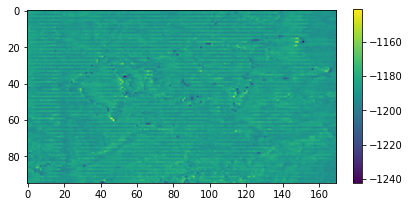

In [22]:
%matplotlib inline
ap = a.reshape(data.shape[0], data.shape[1], -1)
imshow(ap)
colorbar(fraction=0.026)
savefig('doc/acalibration.pdf')
savefig('doc/acalibration.png',dpi=1200)

## Pair compositions

In [23]:
n = len(r)
A = zeros((n,n)) # mixed area
B = zeros((n,n)) # difference

C = trapz(where(r.intensity>0,r.intensity,0)) # C

for i,ra in enumerate(r):
    
    A[i,i] = ra.overlap_area()
    
    for j,rb in enumerate(r[i+1:]):

        union = maximum(ra.z(),rb.z())
        union = minimum(union,r.intensity)
        union = trapz(where(union > 0,union,0))
        
        A[i,i + j + 1] = union
        A[i + j + 1,i] = union
        
        difference = minimum(ra.z(),rb.z())
        difference = minimum(difference,r.intensity)
        difference = trapz(where(difference > 0,difference,0))
        
        B[i,i + j + 1] = difference
        B[i + j + 1,i] = difference

(array([[34.92658008, 36.127122  , 36.58061047],
        [36.127122  , 15.99022988, 17.95342124],
        [36.58061047, 17.95342124,  2.25400284]]),
 array([[ 0.        , 14.78888598,  0.59917046],
        [14.78888598,  0.        ,  0.29081147],
        [ 0.59917046,  0.29081147,  0.        ]]),
 array([[1.        , 0.59064312, 0.98362054],
        [0.59064312, 1.        , 0.98380189],
        [0.98362054, 0.98380189, 1.        ]]))

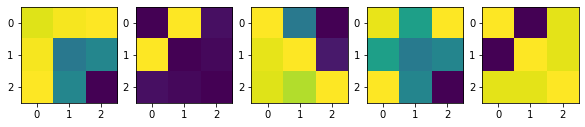

In [24]:
%matplotlib inline

fig,ax = subplots(1,5,figsize=(10,3))
ax[0].imshow(A)
ax[1].imshow(B)

ax[2].imshow(A.diagonal()/A)
ax[3].imshow((A-B))
ax[4].imshow((A-B)/A)

A,B,((A-B)/A)

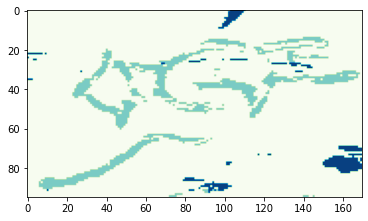

In [25]:
%matplotlib inline
idx = pm.map_best_index()
imshow(idx,cmap='GnBu')

In [26]:
%%time
area = pm.overlap_area()

CPU times: user 5.83 s, sys: 8.06 s, total: 13.9 s
Wall time: 38 s


In [27]:
%%time
area_fit = pm.area_fit()

CPU times: user 5.34 s, sys: 5.48 s, total: 10.8 s
Wall time: 28.8 s


In [28]:
%%time
area_0 = pm.area_0()

CPU times: user 5.82 s, sys: 5.41 s, total: 11.2 s
Wall time: 27.8 s


In [29]:
%%time
loss = pm.loss()

CPU times: user 7.96 s, sys: 5.96 s, total: 13.9 s
Wall time: 29.9 s


In [30]:
%%time
ss = pm.map_intensity()

CPU times: user 76.2 ms, sys: 940 ms, total: 1.02 s
Wall time: 7.54 s


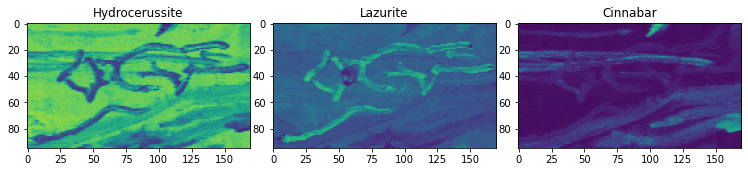

In [33]:
%matplotlib inline
#%matplotlib qt

fig, ax = subplots(1, 3, figsize = (3.5 * len(r), 3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area[:,:,i]/ss,vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)
    
#savefig('doc/maps.png')

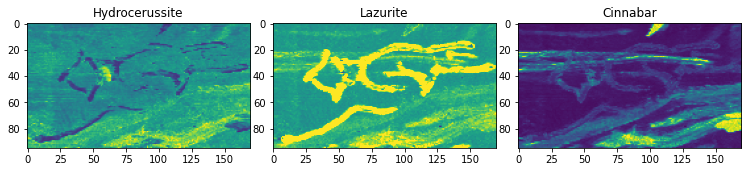

In [32]:
%matplotlib inline
#%matplotlib qt

fig, ax = subplots(1, 3, figsize = (3.5 * len(r), 3))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[i].imshow(area_fit[:,:,i]/area_0[:,:,i],vmin=0,vmax=1)
    ax[i].set_title(r'%s'%g.label)

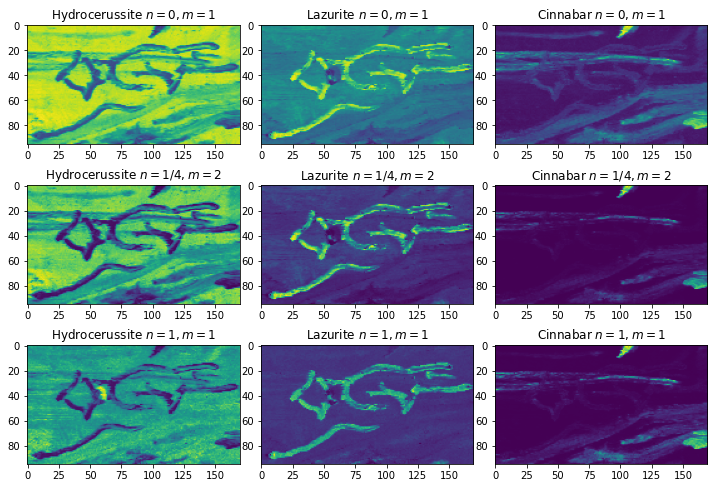

In [34]:
%matplotlib inline

fig, ax = subplots(3, len(r), figsize=(10,7))
fig.subplots_adjust(wspace=0.1,hspace=0.2,top=0.95,bottom=0.05,left=0.04,right=0.985)

for i,g in enumerate(r):
    
    ax[0,i].imshow(area[:,:,i]/ss,vmin=0)
    ax[0,i].set_title(r'%s $n = 0, m=1$'%g.label)
    
    ax[1,i].imshow(((area_fit[:,:,i]/area_0[:,:,i])**0.25 * (area[:,:,i]/ss)**2),vmin=0)
    ax[1,i].set_title(r'%s $n = 1/4, m=2$'%g.label)
    
    ax[2,i].imshow((((area_fit[:,:,i]/area_0[:,:,i]) * (area[:,:,i]/ss))),vmin=0)
    ax[2,i].set_title(r'%s $n = 1,m=1$'%g.label)
    
savefig('doc/wmaps2.png',dpi=1200)
#savefig('doc/wmaps.pdf')

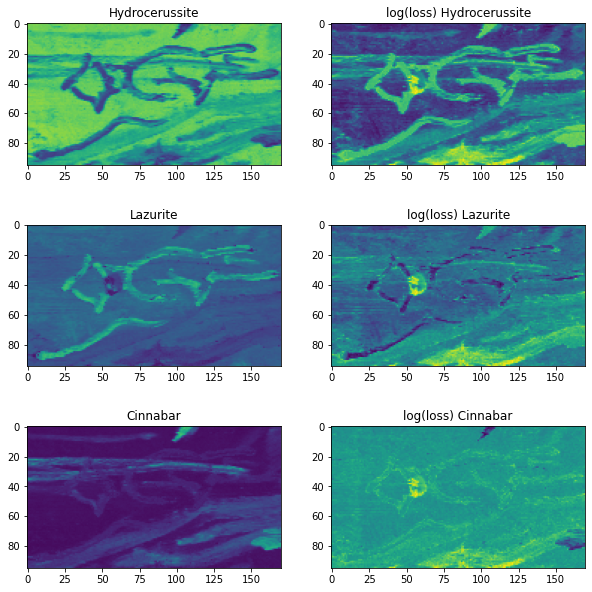

In [35]:
%matplotlib inline
fig, ax = subplots(len(r), 2, figsize = (10, 3.5 * len(r)))

for i,g in enumerate(r):

    ax[i,0].imshow(area[:,:,i]/ss,vmin=0,vmax=1)    
    ax[i,1].imshow(log(loss[:,:,i]))
    
    ax[i,0].set_title(r'%s'%g.label)
    ax[i,1].set_title(r'log(loss) %s'%g.label)

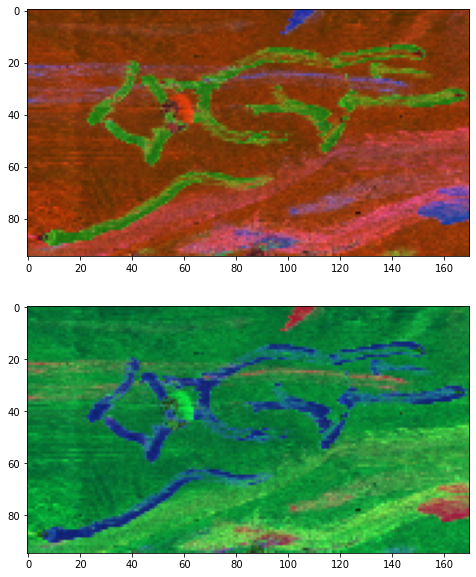

In [36]:
fig, ax = subplots(2, 1, figsize = (10, 10))

zarea = area / max(area)

sarea = zarea[:,:,:3].copy()

sarea[:,:,0] = zarea[:,:,2]
sarea[:,:,1] = zarea[:,:,0]
sarea[:,:,2] = zarea[:,:,1]

ax[0].imshow((zarea[:,:,:3]*255).astype(int))
ax[1].imshow((sarea*255).astype(int))